In [8]:
# import packages
import sys
import datetime
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
%matplotlib notebook

In [5]:
# Loading the dataset
df = pd.read_csv("../../DataSet/mnist_train.csv")

In [6]:
df.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# input and output features
X = df.iloc[:,1:].to_numpy() / 255
Y = df.iloc[:,0].to_numpy()

In [9]:
print(X.shape, Y.shape)

(60000, 784) (60000,)


In [10]:
# Train and Test split
Xtrain, Xtest, Ytrain, Ytest = X[:-1000], X[-1000:], Y[:-1000], Y[-1000:]

In [11]:
# Shuffle the data
Xtrain, Ytrain = shuffle(Xtrain, Ytrain)

In [131]:
def showPic(x,y):
    plt.figure()
    plt.title("Digit: "+str(x))
    plt.imshow(x.reshape(28,28))
    plt.show()

<IPython.core.display.Javascript object>


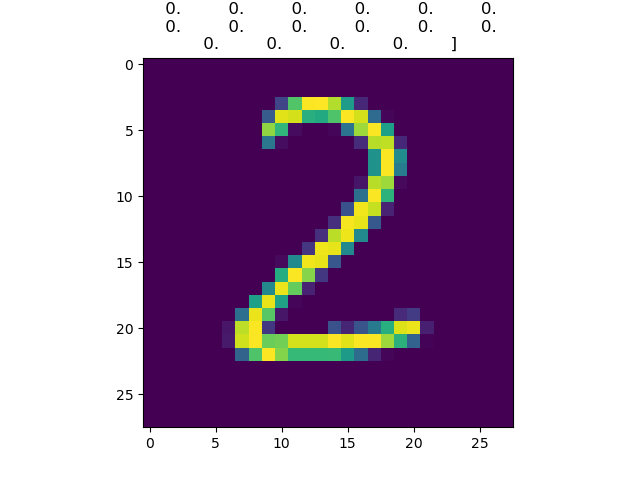

In [132]:
photo_id = 1
showPic(Xtrain[photo_id], Ytrain[photo_id])

In [14]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [15]:
def tanh(z):
    return (np.exp(z)-np.exp(-z)) / (np.exp(z)+np.exp(-z))

In [16]:
def relu(z):
    return z*(z>0)

In [19]:
def softmax(z):
    return np.exp(z) / np.exp(z).sum(axis=1, keepdims=True)

In [17]:
def nonlinearDr(z,activation):
    if activation=="sigmoid":
        return z*(1-z)
    if activation=="tanh":
        return (1-z**2)
    if activation=="relu":
        return (z>0)

In [37]:
def oneHotEncode(Y):
    T = np.zeros((Y.shape[0], np.unique(Y).shape[0]))
    
    for i,val in enumerate(Y):
        T[i,val] = 1
        
    return T

In [18]:
def cost(t,y):
    return -np.sum(t*np.log(y))

In [65]:
def forward(X,T,hidden,activation,W,B,A,i,seed):
    D = X.shape[1]
    K = T.shape[1]
    L = len(hidden)
    np.random.seed(seed)
    
    for l in range(L+1):
        if l==0:
            if i==0:
                W[l] = np.random.randn(D,hidden[l])
                B[l] = np.random.randn(hidden[l])
            A[l] = activation(np.dot(X,W[l])+B[l])
            
        elif l==L:
            if i==0:
                W[l] = np.random.randn(hidden[l-1],K)
                B[l] = np.random.randn(K)
            A[l] = softmax(np.dot(A[l-1],W[l])+B[l])
            Y=A[l]
            
        else:
            if i==0:
                W[l] = np.random.randn(hidden[l-1], hidden[l])
                B[l] = np.random.randn(hidden[l])
            A[l] = activation(np.dot(A[l-1],W[l])+B[l])
            
    return W,B,A,Y

In [120]:
def backprop(X,T,Y,hidden,activation,momentum,lr,W,B,A,Vw,Vb,Vw1,Vb1):
    L = len(hidden)
    E, Grad = {},{}
    
    # Error and Gradient calculation
    for l in range(L,-1,-1):
        if l==L:
            E[l] = T-Y
            Grad[l] = E[l] # Softmax layer

        else:
            E[l] = np.dot(Grad[l+1],W[l+1].T)
            Grad[l] = E[l]*nonlinearDr(A[l], activation.__name__)
    
    # Weight update
    if momentum==0:
        # Normal Gradient Descent Update Rule
        for l in range(L+1):
            if l==0:
                W[l] += lr*np.dot(X.T,Grad[l])
                B[l] += lr*np.sum(Grad[l], axis=0)
            else:
                W[l] += lr*np.dot(A[l-1].T, Grad[l])
                B[l] += lr*np.sum(Grad[l], axis=0)
    else:
        # With Momentum Update Rule
        for l in range(L+1):
            if l==0:
                Vw = Vw*momentum + lr*np.dot(X.T,Grad[l])
                Vb = Vb*momentum + lr*np.sum(Grad[l], axis=0)
                W[l] += Vw
                B[l] += Vb
            else:
                Vw1 = Vw1*momentum + lr*np.dot(A[l-1].T, Grad[l])
                Vb1 = Vb1*momentum + lr*np.sum(Grad[l], axis=0)
                W[l] += Vw1
                B[l] += Vb1
                
    return W,B,Vw,Vb,Vw1,Vb1

In [124]:
def fit(X,Ytrain,Xtest,Ytest,hidden,activation,momentum,lr,seed,iterations):
    T = oneHotEncode(Ytrain)
    Ttest = oneHotEncode(Ytest)
    W,B,A = {},{},{}
    Vw,Vb,Vw1,Vb1 = 0,0,0,0
    Ctrain, Ctest = [],[]
    
    for i in range(iterations):
        W,B,A,Y = forward(X,T,hidden,activation,W,B,A,i,seed) # Forward Propagation (Train Data)
        W,B,Vw,Vb,Vw1,Vb1 = backprop(X,T,Y,hidden,activation,momentum,lr,W,B,A,Vw,Vb,Vw1,Vb1) # Backpropagation (Train Data)
        _,_,_,Yout = forward(Xtest,Ttest,hidden,activation,W,B,A,2,seed) # Forward Propagation (Test Data)
        
        Ctrain.append(cost(T,Y))
        Ctest.append(cost(Ttest, Yout))
        
        sys.stdout.write("\rIterations: {} | Train Cost: {} | Test Cost: {}".format(i+1,cost(T,Y),cost(Ttest, Yout)))
        
    return Ctrain, Ctest, W, B, Y, Yout

In [127]:
# Full Gradient Descent WITHOUT Momentum
start = datetime.datetime.now()
ctrain, ctest, W, B, Yhat, Yhat_test = fit(Xtrain,Ytrain,Xtest,Ytest,[100],sigmoid,momentum=0,lr=0.00001,seed=1,iterations=100)
end = datetime.datetime.now()

print("| Execution Time: ", end-start)

Iterations: 100 | Train Cost: 55412.91336402649 | Test Cost: 732.7934091611014| Execution Time:  0:01:02.145526


In [128]:
# Full Gradient Descent WITH Momentum
start = datetime.datetime.now()
ctrain_m, ctest_m, W_m, B_m, Yhat_m, Yhat_test_m = fit(Xtrain,Ytrain,Xtest,Ytest,[100],sigmoid,momentum=0.95,lr=0.00001,seed=1,iterations=100)
end = datetime.datetime.now()

print("| Execution Time: ", end-start)

Iterations: 100 | Train Cost: 17975.891349089867 | Test Cost: 303.18760444030255| Execution Time:  0:01:02.366991


<IPython.core.display.Javascript object>


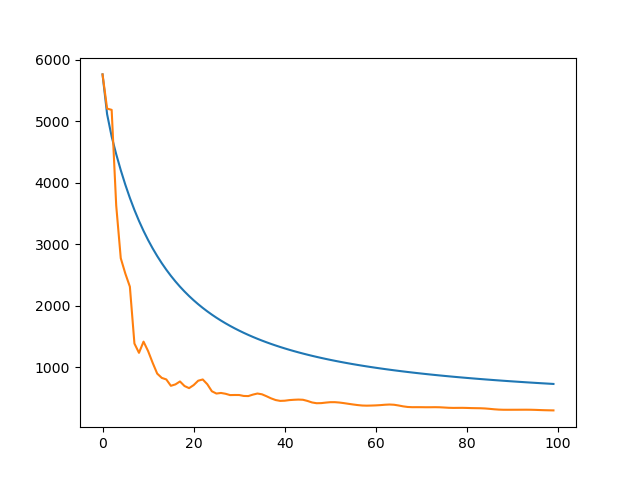

In [133]:
plt.figure()
plt.plot(ctest)
plt.plot(ctest_m)
plt.show()